In [1]:
import csv
import collections

import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate
import scipy.signal

In [2]:
def read_data(filename):
    times = []   # sec
    flows = []   # L/sec
    with open(filename) as file:
        start_fill = False
        for line in csv.reader(file):
            if start_fill:
                times.append(float(line[1].replace(",", "")))
                flows.append(np.sign(float(line[2]))*abs(float(line[2]) / 0.0538)**(4.0/7.0) / 60.0)
            if line[0] == "Sample #":
                start_fill = True
    return collections.namedtuple("TimesFlows", ["times", "flows"])(np.array(times), np.array(flows))

first = read_data("../sample-data/Sensirion_Philippe.csv")
normal = read_data("../sample-data/Sensirion_Philippe_normal.csv")
strong = read_data("../sample-data/Sensirion_Philippe_strongl.csv")

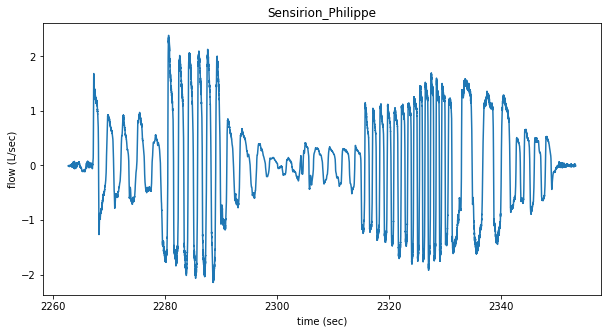

In [3]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.plot(first.times, first.flows)
ax.set_title("Sensirion_Philippe")
ax.set_xlabel("time (sec)")
ax.set_ylabel("flow (L/sec)")
fig.savefig("Sensirion_Philippe.png")

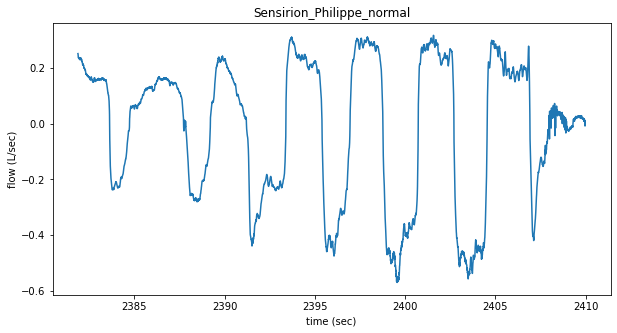

In [4]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.plot(normal.times, normal.flows)
ax.set_title("Sensirion_Philippe_normal")
ax.set_xlabel("time (sec)")
ax.set_ylabel("flow (L/sec)")
fig.savefig("Sensirion_Philippe_normal.png")

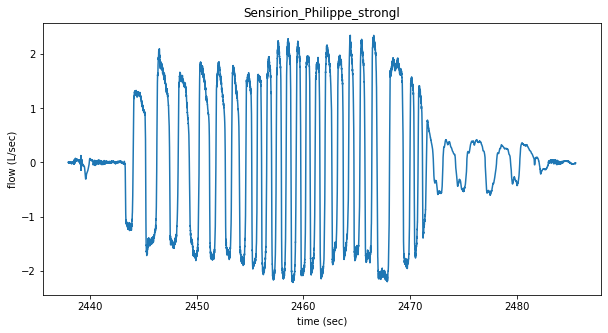

In [5]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.plot(strong.times, strong.flows)
ax.set_title("Sensirion_Philippe_strongl")
ax.set_xlabel("time (sec)")
ax.set_ylabel("flow (L/sec)")
fig.savefig("Sensirion_Philippe_strongl.png")

In [6]:
def compute_volume(dataset):
    volumes = scipy.integrate.cumtrapz(dataset.flows, dataset.times)
    filtered = scipy.signal.sosfilt(scipy.signal.butter(1, 0.003, "highpass", output="sos"), volumes)
    return collections.namedtuple("TimesFlowsVolumes", ["times", "flows", "volumes", "filtered"])(
        dataset.times[:-1], dataset.flows[:-1], volumes, filtered)

first = compute_volume(first)
normal = compute_volume(normal)
strong = compute_volume(strong)

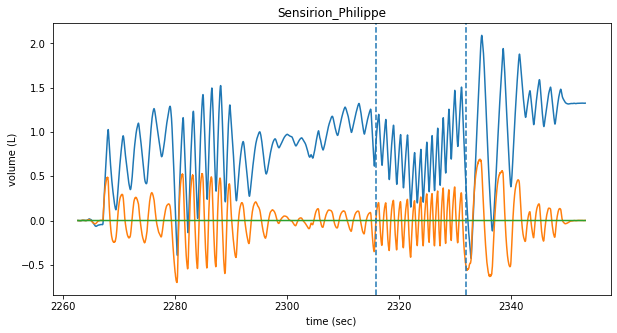

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.plot(first.times, first.volumes)
ax.plot(first.times, first.filtered)
ax.plot(first.times, np.zeros(len(first.times)))
ax.axvline(2316, linestyle="--")
ax.axvline(2332, linestyle="--")
ax.set_title("Sensirion_Philippe")
ax.set_xlabel("time (sec)")
ax.set_ylabel("volume (L)")
fig.savefig("Sensirion_Philippe-volume.png")

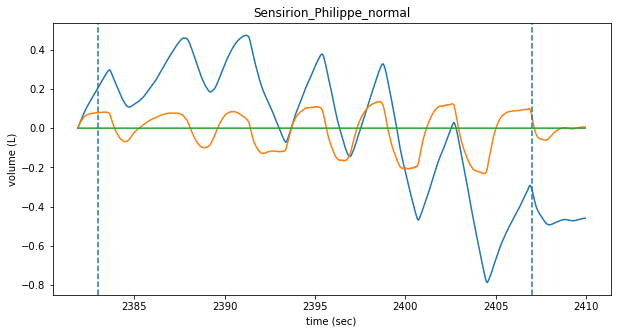

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.plot(normal.times, normal.volumes)
ax.plot(normal.times, normal.filtered)
ax.plot(normal.times, np.zeros(len(normal.times)))
ax.axvline(2383, linestyle="--")
ax.axvline(2407, linestyle="--")
ax.set_title("Sensirion_Philippe_normal")
ax.set_xlabel("time (sec)")
ax.set_ylabel("volume (L)")
fig.savefig("Sensirion_Philippe_normal-volume.png")

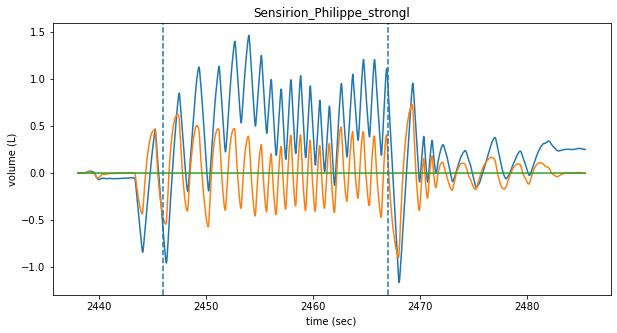

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.plot(strong.times, strong.volumes)
ax.plot(strong.times, strong.filtered)
ax.plot(strong.times, np.zeros(len(strong.times)))
ax.axvline(2446, linestyle="--")
ax.axvline(2467, linestyle="--")
ax.set_title("Sensirion_Philippe_strongl")
ax.set_xlabel("time (sec)")
ax.set_ylabel("volume (L)")
fig.savefig("Sensirion_Philippe_strongl-volume.png")

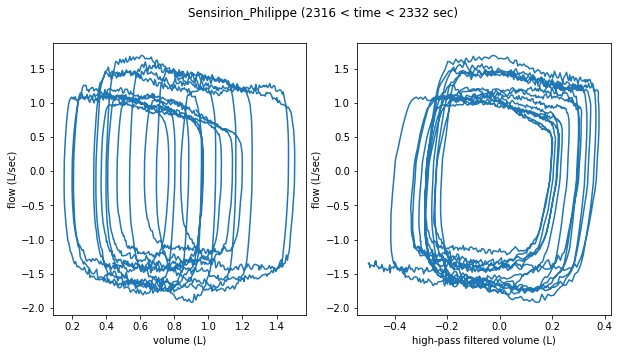

In [10]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
timecut = np.logical_and(2316 < first.times, first.times < 2332)
ax1.plot(first.volumes[timecut], first.flows[timecut])
ax1.set_xlabel("volume (L)")
ax1.set_ylabel("flow (L/sec)")
ax2.plot(first.filtered[timecut], first.flows[timecut])
ax2.set_xlabel("high-pass filtered volume (L)")
ax2.set_ylabel("flow (L/sec)")
fig.suptitle("Sensirion_Philippe (2316 < time < 2332 sec)")
fig.savefig("Sensirion_Philippe-phase.png")

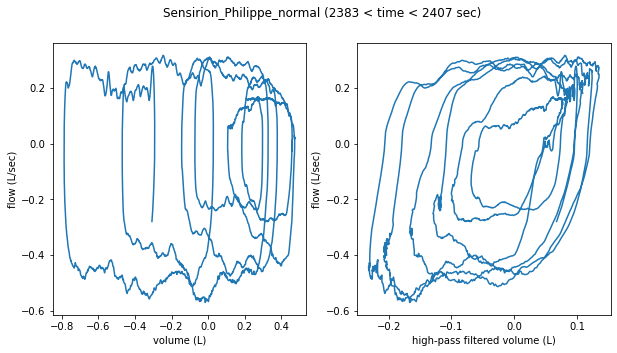

In [11]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
timecut = np.logical_and(2383 < normal.times, normal.times < 2407)
ax1.plot(normal.volumes[timecut], normal.flows[timecut])
ax1.set_xlabel("volume (L)")
ax1.set_ylabel("flow (L/sec)")
ax2.plot(normal.filtered[timecut], normal.flows[timecut])
ax2.set_xlabel("high-pass filtered volume (L)")
ax2.set_ylabel("flow (L/sec)")
fig.suptitle("Sensirion_Philippe_normal (2383 < time < 2407 sec)")
fig.savefig("Sensirion_Philippe_normal-phase.png")

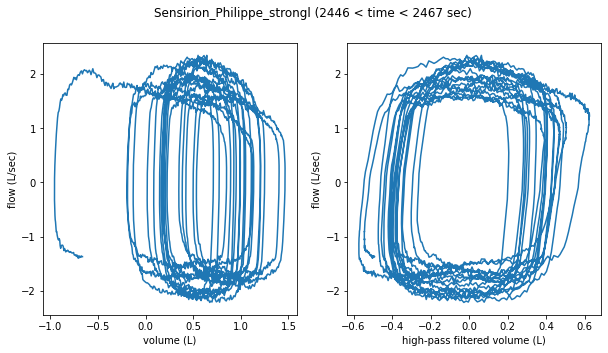

In [12]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
timecut = np.logical_and(2446 < strong.times, strong.times < 2467)
ax1.plot(strong.volumes[timecut], strong.flows[timecut])
ax1.set_xlabel("volume (L)")
ax1.set_ylabel("flow (L/sec)")
ax2.plot(strong.filtered[timecut], strong.flows[timecut])
ax2.set_xlabel("high-pass filtered volume (L)")
ax2.set_ylabel("flow (L/sec)")
fig.suptitle("Sensirion_Philippe_strongl (2446 < time < 2467 sec)")
fig.savefig("Sensirion_Philippe_strongl-phase.png")

In [13]:
length = 8
window = 5

dtype = np.dtype(np.int64)
np.lib.stride_tricks.as_strided(np.arange(length, dtype=dtype), (length - window + 1, window), (dtype.itemsize, dtype.itemsize))

array([[0, 1, 2, 3, 4],
       [1, 2, 3, 4, 5],
       [2, 3, 4, 5, 6],
       [3, 4, 5, 6, 7]])

In [14]:
def smooth_derivative(times, values, sig):
    window_width = int(np.ceil(4*sig/np.min(times[1:] - times[:-1])))
    windowed_times  = np.lib.stride_tricks.as_strided(times,
                                                      (len(times) - window_width + 1, window_width),
                                                      (times.itemsize, times.itemsize))
    windowed_values = np.lib.stride_tricks.as_strided(values,
                                                      (len(values) - window_width + 1, window_width),
                                                      (values.itemsize, values.itemsize))

    centers = np.mean(windowed_times, axis=1)
    windowed_times_centered = windowed_times - centers[:, np.newaxis]
    windowed_weights = np.exp(-0.5 * windowed_times_centered**2 / sig**2)
    sumw   = np.sum(windowed_weights, axis=1)
    sumwx  = np.sum(windowed_weights * windowed_times_centered, axis=1)
    sumwy  = np.sum(windowed_weights * windowed_values, axis=1)
    sumwxx = np.sum(windowed_weights * windowed_times_centered * windowed_times_centered, axis=1)
    sumwxy = np.sum(windowed_weights * windowed_times_centered * windowed_values, axis=1)
    delta     = (sumw*sumwxx) - (sumwx*sumwx)
    intercept = ((sumwxx*sumwy) - (sumwx*sumwxy)) / delta
    slope     = ((sumw*sumwxy) - (sumwx*sumwy)) / delta
    
    return centers, intercept, slope

In [35]:
def roots(times, values, other, other_threshold):
    lefts, = np.nonzero(np.logical_and(np.sign(values[:-1]) != np.sign(values[1:]), abs(0.5*(other[:-1] + other[1:])) > other_threshold*np.max(abs(other))))
    rights = lefts + 1
    return lefts, rights, 0.5*(times[rights] + times[lefts])

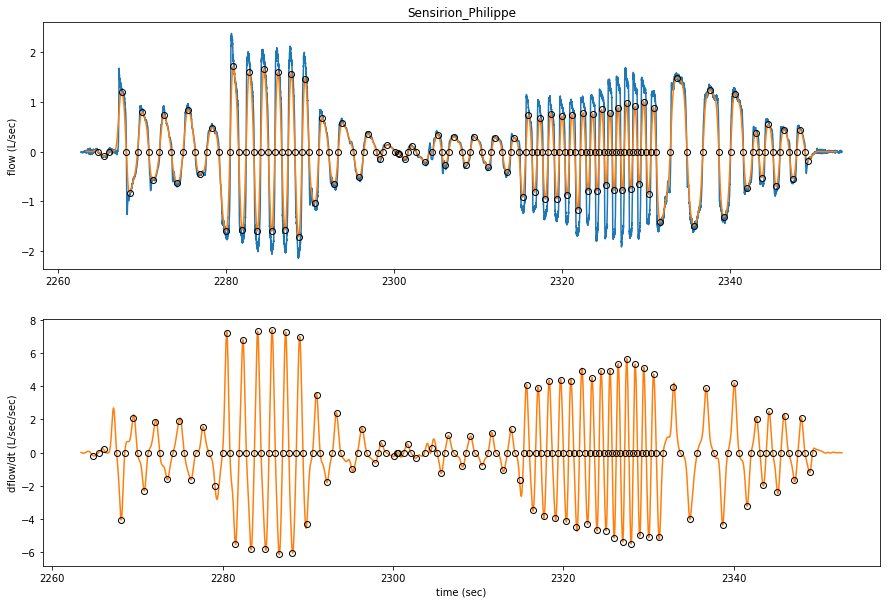

In [16]:
centers, intercept, slope = smooth_derivative(first.times, first.flows, 0.2)
intercept_lefts, intercept_rights, intercept_roots = roots(centers, intercept, slope, 0.02)
slope_lefts, slope_rights, slope_roots = roots(centers, slope, intercept, 0.02)
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))
ax1.plot(first.times, first.flows)
ax1.plot(centers, intercept)
ax1.plot(intercept_roots, np.zeros(len(intercept_roots)), "o", c="black", fillstyle="none")
ax1.plot(slope_roots, 0.5*(intercept[slope_lefts] + intercept[slope_rights]), "o", c="black", fillstyle="none")
ax1.set_ylabel("flow (L/sec)")
ax1.set_title("Sensirion_Philippe")
ax2.plot(centers, slope, c="#ff7f0e")
ax2.plot(slope_roots, np.zeros(len(slope_roots)), "o", c="black", fillstyle="none")
ax2.plot(intercept_roots, 0.5*(slope[intercept_lefts] + slope[intercept_rights]), "o", c="black", fillstyle="none")
ax2.set_xlabel("time (sec)")
ax2.set_ylabel("dflow/dt (L/sec/sec)")
fig.savefig("Sensirion_Philippe-derivative.png")

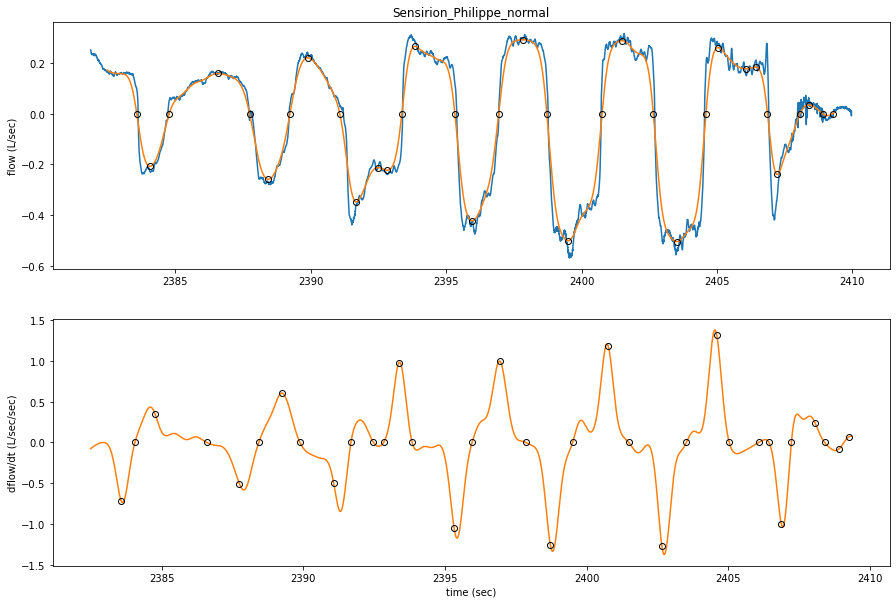

In [17]:
centers, intercept, slope = smooth_derivative(normal.times, normal.flows, 0.2)
intercept_lefts, intercept_rights, intercept_roots = roots(centers, intercept, slope, 0.02)
slope_lefts, slope_rights, slope_roots = roots(centers, slope, intercept, 0.02)
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))
ax1.plot(normal.times, normal.flows)
ax1.plot(centers, intercept)
ax1.plot(intercept_roots, np.zeros(len(intercept_roots)), "o", c="black", fillstyle="none")
ax1.plot(slope_roots, 0.5*(intercept[slope_lefts] + intercept[slope_rights]), "o", c="black", fillstyle="none")
ax1.set_ylabel("flow (L/sec)")
ax1.set_title("Sensirion_Philippe_normal")
ax2.plot(centers, slope, c="#ff7f0e")
ax2.plot(slope_roots, np.zeros(len(slope_roots)), "o", c="black", fillstyle="none")
ax2.plot(intercept_roots, 0.5*(slope[intercept_lefts] + slope[intercept_rights]), "o", c="black", fillstyle="none")
ax2.set_xlabel("time (sec)")
ax2.set_ylabel("dflow/dt (L/sec/sec)")
fig.savefig("Sensirion_Philippe_normal-derivative.png")

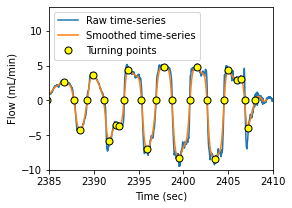

In [57]:
centers, intercept, slope = smooth_derivative(normal.times, normal.flows, 0.2)
intercept_lefts, intercept_rights, intercept_roots = roots(centers, intercept, slope, 0.08)
slope_lefts, slope_rights, slope_roots = roots(centers, slope, intercept, 0.08)
fig, ax1 = plt.subplots(1, 1, figsize=(4, 3))
raw, = ax1.plot(normal.times, normal.flows*1000/60)
smooth, = ax1.plot(centers, intercept*1000/60)
turns, = ax1.plot(intercept_roots, np.zeros(len(intercept_roots))*1000/60, "o", c="yellow", markeredgecolor="black", markersize=7, fillstyle="full")
ax1.plot(slope_roots, 0.5*(intercept[slope_lefts] + intercept[slope_rights])*1000/60, "o", c="yellow", markeredgecolor="black", markersize=7, fillstyle="full")
ax1.set_xlim(2385, 2410)
ax1.set_ylabel("Flow (mL/min)")
ax1.set_xlabel("Time (sec)")
ax1.set_ylim(-10, 13.5)
ax1.legend([raw, smooth, turns], ["Raw time-series", "Smoothed time-series", "Turning points"], loc="upper left")
fig.savefig("turning_points.svg")

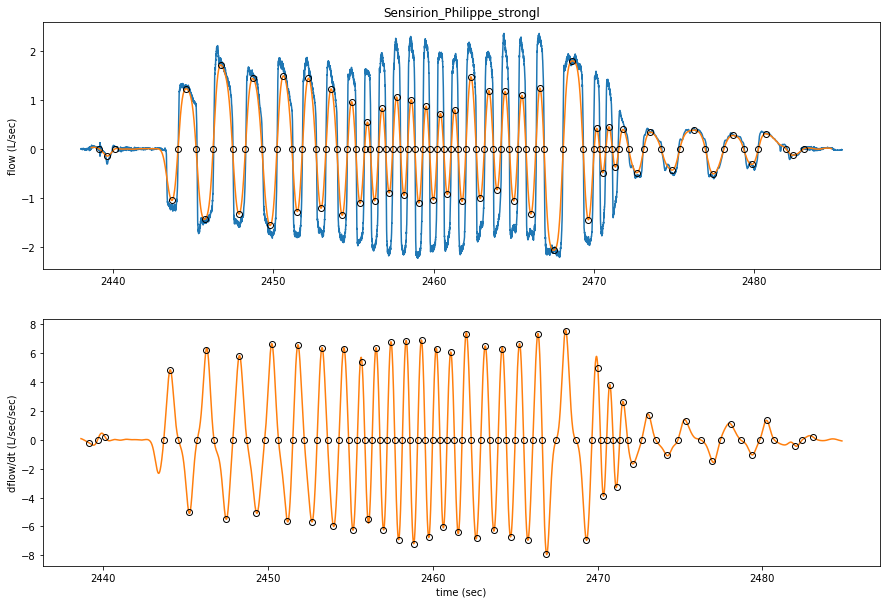

In [34]:
centers, intercept, slope = smooth_derivative(strong.times, strong.flows, 0.2)
intercept_lefts, intercept_rights, intercept_roots = roots(centers, intercept, slope, 0.02)
slope_lefts, slope_rights, slope_roots = roots(centers, slope, intercept, 0.02)
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))
ax1.plot(strong.times, strong.flows)
ax1.plot(centers, intercept)
ax1.plot(intercept_roots, np.zeros(len(intercept_roots)), "o", c="black", fillstyle="none")
ax1.plot(slope_roots, 0.5*(intercept[slope_lefts] + intercept[slope_rights]), "o", c="black", fillstyle="none")
ax1.set_ylabel("flow (L/sec)")
ax1.set_title("Sensirion_Philippe_strongl")
ax2.plot(centers, slope, c="#ff7f0e")
ax2.plot(slope_roots, np.zeros(len(slope_roots)), "o", c="black", fillstyle="none")
ax2.plot(intercept_roots, 0.5*(slope[intercept_lefts] + slope[intercept_rights]), "o", c="black", fillstyle="none")
ax2.set_xlabel("time (sec)")
ax2.set_ylabel("dflow/dt (L/sec/sec)")
fig.savefig("Sensirion_Philippe_strongl-derivative.png")

In [35]:
threshold = 0.02  # of value or slope maximum

def find_breaths(times, values, derivative):
    values_threshold = threshold*np.max(abs(values))
    derivative_threshold = threshold*np.max(abs(derivative))

    A, = np.nonzero((values[:-1] < 0) & (values[1:] >= 0) & (0.5*(derivative[:-1] + derivative[1:]) >= derivative_threshold))
    B, = np.nonzero((derivative[:-1] >= 0) & (derivative[1:] < 0) & (0.5*(values[:-1] + values[1:]) >= values_threshold))
    C, = np.nonzero((values[:-1] >= 0) & (values[1:] < 0) & (0.5*(derivative[:-1] + derivative[1:]) < -derivative_threshold))
    D, = np.nonzero((derivative[:-1] < 0) & (derivative[1:] >= 0) & (0.5*(values[:-1] + values[1:]) < -values_threshold))

    return 0.5*(times[A] + times[A + 1]), 0.5*(times[B] + times[B + 1]), 0.5*(times[C] + times[C + 1]), 0.5*(times[D] + times[D + 1])

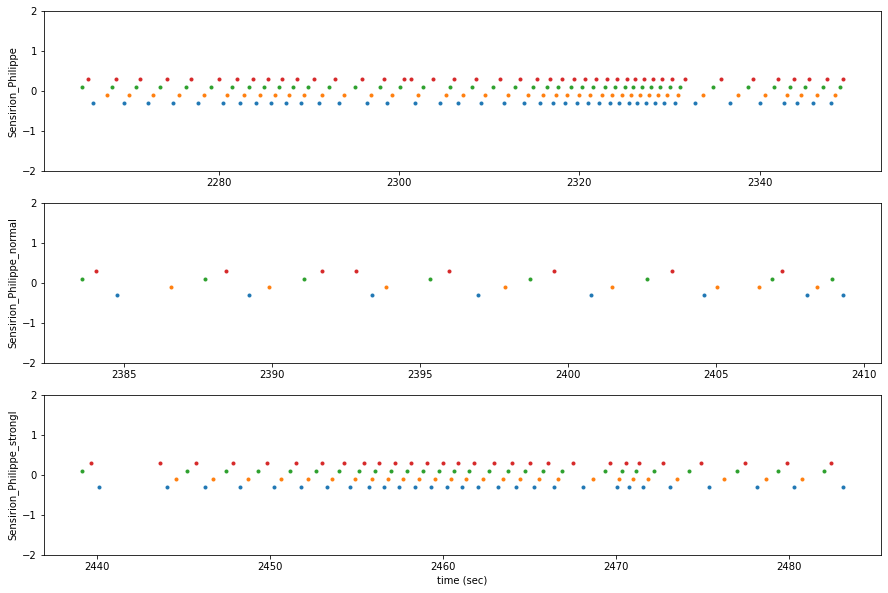

In [36]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(15, 10))

centers, intercept, slope = smooth_derivative(first.times, first.flows, 0.2)
A, B, C, D = find_breaths(centers, intercept, slope)
ax1.plot(A, np.zeros(len(A)) - 0.3, ".")
ax1.plot(B, np.zeros(len(B)) - 0.1, ".")
ax1.plot(C, np.zeros(len(C)) + 0.1, ".")
ax1.plot(D, np.zeros(len(D)) + 0.3, ".")
ax1.set_ylim(-2, 2)
ax1.set_ylabel("Sensirion_Philippe")

centers, intercept, slope = smooth_derivative(normal.times, normal.flows, 0.2)
A, B, C, D = find_breaths(centers, intercept, slope)
ax2.plot(A, np.zeros(len(A)) - 0.3, ".")
ax2.plot(B, np.zeros(len(B)) - 0.1, ".")
ax2.plot(C, np.zeros(len(C)) + 0.1, ".")
ax2.plot(D, np.zeros(len(D)) + 0.3, ".")
ax2.set_ylim(-2, 2)
ax2.set_ylabel("Sensirion_Philippe_normal")

centers, intercept, slope = smooth_derivative(strong.times, strong.flows, 0.2)
A, B, C, D = find_breaths(centers, intercept, slope)
ax3.plot(A, np.zeros(len(A)) - 0.3, ".")
ax3.plot(B, np.zeros(len(B)) - 0.1, ".")
ax3.plot(C, np.zeros(len(C)) + 0.1, ".")
ax3.plot(D, np.zeros(len(D)) + 0.3, ".")
ax3.set_ylim(-2, 2)
ax3.set_ylabel("Sensirion_Philippe_strongl")
ax3.set_xlabel("time (sec)")

fig.savefig("Sensirion_Philippe_all-turning-points.png")

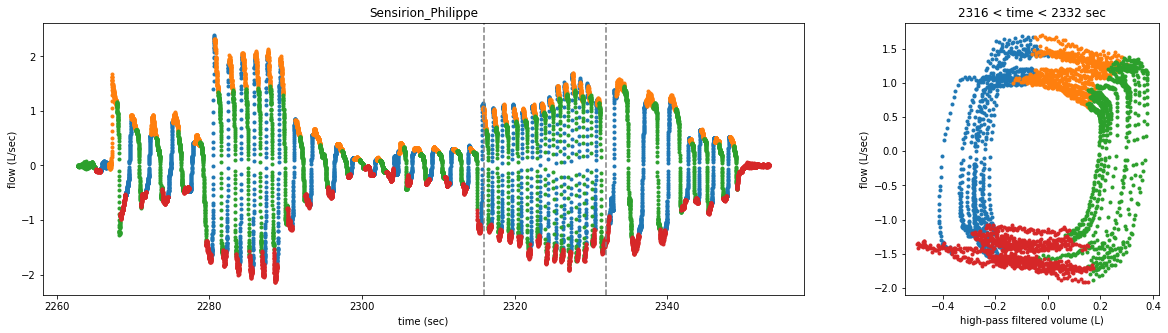

In [37]:
centers, intercept, slope = smooth_derivative(first.times, first.flows, 0.2)
A, B, C, D = find_breaths(centers, intercept, slope)
diff_A = np.min(abs(first.times[:, np.newaxis] - A[np.newaxis, :]), axis=1)
diff_B = np.min(abs(first.times[:, np.newaxis] - B[np.newaxis, :]), axis=1)
diff_C = np.min(abs(first.times[:, np.newaxis] - C[np.newaxis, :]), axis=1)
diff_D = np.min(abs(first.times[:, np.newaxis] - D[np.newaxis, :]), axis=1)

mask_A = (diff_A < diff_B) & (diff_A < diff_C) & (diff_A < diff_D)
mask_B = (diff_B < diff_A) & (diff_B < diff_C) & (diff_B < diff_D)
mask_C = (diff_C < diff_A) & (diff_C < diff_B) & (diff_C < diff_D)
mask_D = (diff_D < diff_A) & (diff_D < diff_B) & (diff_D < diff_C)

fig, (ax1, ax2) = plt.subplots(1, 2, gridspec_kw={"width_ratios": [3, 1]}, figsize=(20, 5))
ax1.plot(first.times[mask_A], first.flows[mask_A], ".")
ax1.plot(first.times[mask_B], first.flows[mask_B], ".")
ax1.plot(first.times[mask_C], first.flows[mask_C], ".")
ax1.plot(first.times[mask_D], first.flows[mask_D], ".")

ax1.axvline(2316, linestyle="--", c="gray")
ax1.axvline(2332, linestyle="--", c="gray")
ax1.set_title("Sensirion_Philippe")
ax1.set_xlabel("time (sec)")
ax1.set_ylabel("flow (L/sec)")

timecut = np.logical_and(2316 < first.times, first.times < 2332)
ax2.plot(first.filtered[timecut & mask_A], first.flows[timecut & mask_A], ".")
ax2.plot(first.filtered[timecut & mask_B], first.flows[timecut & mask_B], ".")
ax2.plot(first.filtered[timecut & mask_C], first.flows[timecut & mask_C], ".")
ax2.plot(first.filtered[timecut & mask_D], first.flows[timecut & mask_D], ".")
ax2.set_xlabel("high-pass filtered volume (L)")
ax2.set_ylabel("flow (L/sec)")
ax2.set_title("2316 < time < 2332 sec")

fig.savefig("Sensirion_Philippe-labeled.png")

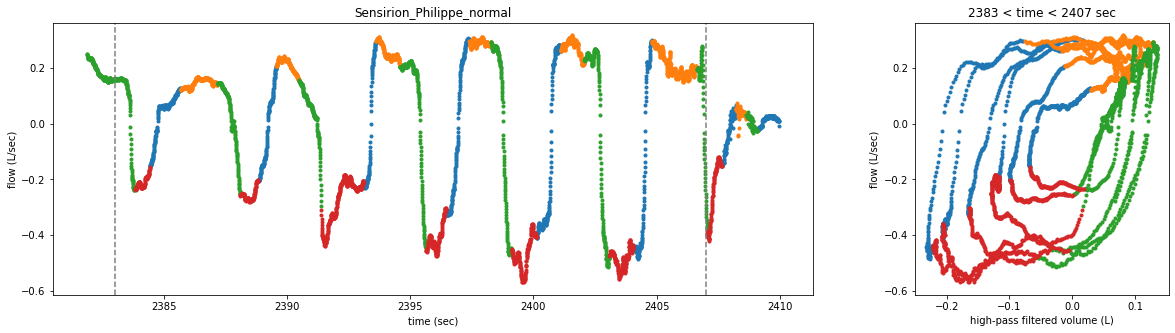

In [38]:
centers, intercept, slope = smooth_derivative(normal.times, normal.flows, 0.2)
A, B, C, D = find_breaths(centers, intercept, slope)
diff_A = np.min(abs(normal.times[:, np.newaxis] - A[np.newaxis, :]), axis=1)
diff_B = np.min(abs(normal.times[:, np.newaxis] - B[np.newaxis, :]), axis=1)
diff_C = np.min(abs(normal.times[:, np.newaxis] - C[np.newaxis, :]), axis=1)
diff_D = np.min(abs(normal.times[:, np.newaxis] - D[np.newaxis, :]), axis=1)

mask_A = (diff_A < diff_B) & (diff_A < diff_C) & (diff_A < diff_D)
mask_B = (diff_B < diff_A) & (diff_B < diff_C) & (diff_B < diff_D)
mask_C = (diff_C < diff_A) & (diff_C < diff_B) & (diff_C < diff_D)
mask_D = (diff_D < diff_A) & (diff_D < diff_B) & (diff_D < diff_C)

fig, (ax1, ax2) = plt.subplots(1, 2, gridspec_kw={"width_ratios": [3, 1]}, figsize=(20, 5))
ax1.plot(normal.times[mask_A], normal.flows[mask_A], ".")
ax1.plot(normal.times[mask_B], normal.flows[mask_B], ".")
ax1.plot(normal.times[mask_C], normal.flows[mask_C], ".")
ax1.plot(normal.times[mask_D], normal.flows[mask_D], ".")

ax1.axvline(2383, linestyle="--", c="gray")
ax1.axvline(2407, linestyle="--", c="gray")
ax1.set_title("Sensirion_Philippe_normal")
ax1.set_xlabel("time (sec)")
ax1.set_ylabel("flow (L/sec)")

timecut = np.logical_and(2383 < normal.times, normal.times < 2407)
ax2.plot(normal.filtered[timecut & mask_A], normal.flows[timecut & mask_A], ".")
ax2.plot(normal.filtered[timecut & mask_B], normal.flows[timecut & mask_B], ".")
ax2.plot(normal.filtered[timecut & mask_C], normal.flows[timecut & mask_C], ".")
ax2.plot(normal.filtered[timecut & mask_D], normal.flows[timecut & mask_D], ".")
ax2.set_xlabel("high-pass filtered volume (L)")
ax2.set_ylabel("flow (L/sec)")
ax2.set_title("2383 < time < 2407 sec")

fig.savefig("Sensirion_Philippe_normal-labeled.png")

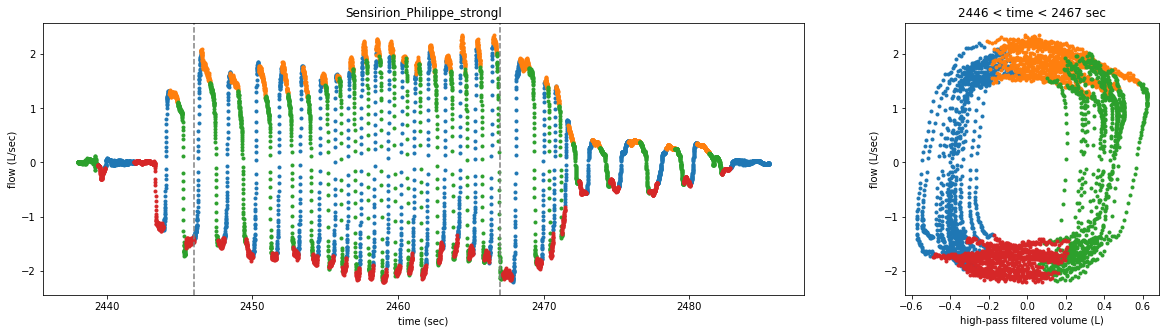

In [39]:
centers, intercept, slope = smooth_derivative(strong.times, strong.flows, 0.2)
A, B, C, D = find_breaths(centers, intercept, slope)
diff_A = np.min(abs(strong.times[:, np.newaxis] - A[np.newaxis, :]), axis=1)
diff_B = np.min(abs(strong.times[:, np.newaxis] - B[np.newaxis, :]), axis=1)
diff_C = np.min(abs(strong.times[:, np.newaxis] - C[np.newaxis, :]), axis=1)
diff_D = np.min(abs(strong.times[:, np.newaxis] - D[np.newaxis, :]), axis=1)

mask_A = (diff_A < diff_B) & (diff_A < diff_C) & (diff_A < diff_D)
mask_B = (diff_B < diff_A) & (diff_B < diff_C) & (diff_B < diff_D)
mask_C = (diff_C < diff_A) & (diff_C < diff_B) & (diff_C < diff_D)
mask_D = (diff_D < diff_A) & (diff_D < diff_B) & (diff_D < diff_C)

fig, (ax1, ax2) = plt.subplots(1, 2, gridspec_kw={"width_ratios": [3, 1]}, figsize=(20, 5))
ax1.plot(strong.times[mask_A], strong.flows[mask_A], ".")
ax1.plot(strong.times[mask_B], strong.flows[mask_B], ".")
ax1.plot(strong.times[mask_C], strong.flows[mask_C], ".")
ax1.plot(strong.times[mask_D], strong.flows[mask_D], ".")

ax1.axvline(2446, linestyle="--", c="gray")
ax1.axvline(2467, linestyle="--", c="gray")
ax1.set_title("Sensirion_Philippe_strongl")
ax1.set_xlabel("time (sec)")
ax1.set_ylabel("flow (L/sec)")

timecut = np.logical_and(2446 < strong.times, strong.times < 2467)
ax2.plot(strong.filtered[timecut & mask_A], strong.flows[timecut & mask_A], ".")
ax2.plot(strong.filtered[timecut & mask_B], strong.flows[timecut & mask_B], ".")
ax2.plot(strong.filtered[timecut & mask_C], strong.flows[timecut & mask_C], ".")
ax2.plot(strong.filtered[timecut & mask_D], strong.flows[timecut & mask_D], ".")
ax2.set_xlabel("high-pass filtered volume (L)")
ax2.set_ylabel("flow (L/sec)")
ax2.set_title("2446 < time < 2467 sec")

fig.savefig("Sensirion_Philippe_strongl-labeled.png")